<h1 align="center">Volume 3: Data Augmentation.</h1>

    Spencer Halverson
    MATH 403
    10/19/2021

In [56]:
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn import datasets
from sklearn.metrics import recall_score, accuracy_score
from scipy.stats import norm
import numpy as np
from imageio import imread
import librosa
import librosa.display

In [49]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

<h2 align="center">Image Augmentation</h2>

<h3 align="center">Problem 1</h3>

In [ ]:
def translate(image, A, B): 
    """Returns image translated by a random amount (a,b), where
    a~Uniform(-A,A) and b~Uniform(-B,B). The resulting image should be cropped
    to be of size (d1,d2). Note that this translation will leave a border on
    two sides of the image. Fill the empty border with the parts that were cropped
    off the opposite sides.
        Parameters:
            image (d1,d2): d1 x d2 array 
            A (float): horizontal translation parameter
            B (float): vertical translation parameter
        Returns:
            translated_image (d1,d2): array of translated image
    """
    # a in unif(-A, A)
    a = int(np.random.random()*2*A - A)
    # b in unif(-B, B)
    b = int(np.random.random()*2*B - B)


    # Translate
    translate_image = np.hstack((image[:, a:], image[:, :a]))
    translate_image = np.vstack((translate_image[b:, :], translate_image[:b, :]))

    return translate_image
    
    
def rotate(image, theta): 
    """ Returns an image rotated by a random amount t~Uniform(-theta,theta).
    The resulting image should be cropped to be the same size as the original,
    and any blank parts should be filled with one of the parts cropped off the
    other side.
        Parameters:
            image (d1,d2): d1 x d2 array
            theta (float): largest acceptable rotation angle
        Returns:
            rotated_image (d1,d2): array of rotated image
    """
    # get random parameter T in unif(-theta, theta)
    T = np.random.random()*2*theta - theta
    # define rotation matrix
    rotate_matrix = np.array([[np.cos(T), -1*np.sin(T)],
                       [np.sin(T), np.cos(T)]])

    d1, d2 = image.shape
    # get coords
    coords = np.mgrid[0:d1, 0:d2].reshape((2, d1*d2))
    new_coords = rotate_matrix@coords

    # convert coords to ints
    new_coords = new_coords.astype(int)

    # apply transformation to image
    x, y = new_coords.reshape((2, d1, d2), order='F')
    rotated_image = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))
    
    return rotated_image

    
def skew(image, A): 
    """ Returns an image with the linear transformation [[1,a],[0,1]] applied,
    where a~Uniform(-A,A). Crop the parts that go outside the image boundaries
    and fill missing areas with the appropriate cropped piece.
        Parameters:
            images (d1,d2): d1 x d2 array
            A (float): skew parameter
        Returns:
            skewed_image (d1,d2): array of skewed image
    """
    # get random parameter a in unif(-A, A)
    a = np.random.random()*2*A - A
    # define skew matrix
    skew_matrix = np.array([[1, a],
                            [0, 1]])

    d1, d2 = image.shape
    # get coords
    coords = np.mgrid[0:d1, 0:d2].reshape((2, d1*d2))
    new_coords = skew_matrix@coords

    # convert coords to ints
    new_coords = new_coords.astype(int)

    # apply skew transformation to image
    x, y = new_coords.reshape((2, d1, d2), order='F')
    skewed_image = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))
    
    return skewed_image
    

def flip_horizontal(image):
    """Flip horizontal. Returns a horizontally flipped version of each image.
        Parameters:
            image (d1,d2): d1 x d2 image array 
        Returns:
            flipped_image (d1,d2): array of flipped image
    """
    # Flip horizontal
    flip_image = image[:, ::-1]

    return flip_image

    
def gauss_noise(image, sigma2): 
    """Adds Gaussian noise with parameter sigma2. For each image draw d1xd2 random
    noise values from N(0,sigma2) and add those to the original image.
        Parameters:
            image (d1,d2): d1 x d2 array 
        Returns:
            noisy_image: array of noisy image
    """
    # get shape of image
    d1,d2 = image.shape

    # get Gaussian noise
    noise = np.random.normal(scale=np.sqrt(sigma2),size=(d1,d2))

    # add noise to image
    noisy_image = noise + image
    return noisy_image
    

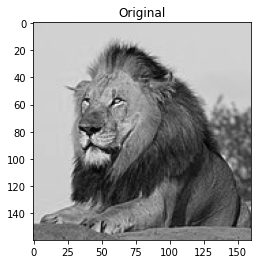

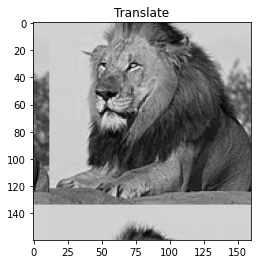

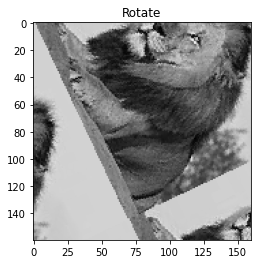

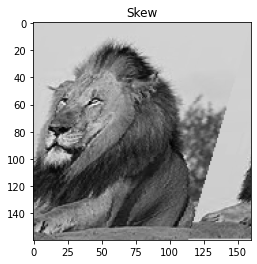

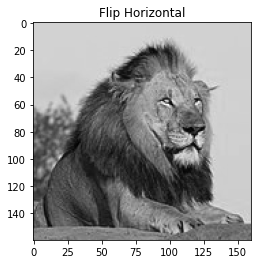

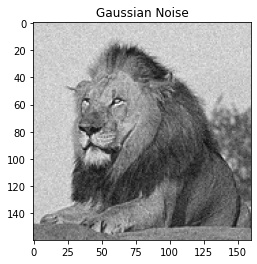

In [ ]:
lion = imread('lion.png')
plt.title("Original")
plt.imshow(lion, cmap = 'gray')
plt.show()
plt.title("Translate")
plt.imshow(translate(lion, 50, 50), cmap='gray')
plt.show()
plt.title("Rotate")
plt.imshow(rotate(lion, 50), cmap='gray')
plt.show()
plt.title("Skew")
plt.imshow(skew(lion, 0.5), cmap='gray')
plt.show()
plt.title("Flip Horizontal")
plt.imshow(flip_horizontal(lion), cmap='gray')
plt.show()
plt.title("Gaussian Noise")
plt.imshow(gauss_noise(lion, 100), cmap='gray')
plt.show()

<h3 align="center"> Problem 2 </h3>
Take the sklearn digits dataset, make an 80-20 train-test split, then apply 
each of your transformations to the entire training set. You must decide good 
values of each of the parameters to use---justify each choice.
This should give you a larger (augmented) training set with roughly 8,600 
training points. Fit a random forest to the augmented training set and to the 
original training set and return the results of each on the test set. 

In [ ]:
def image_augment(X,Y,parameters):
    """ transform the images using the functions above. 
    Parameters:
        X (N,d1,d2): array containing N images of dimension d1 x d2
        Y (N,): Labels/values for each image
        parameters: List of parameter values [A,B,theta,A,sigma2]
    Returns:
        augmented_X (6N,d1,d2): original and transformed data in one array 
        augmented_Y (6N): corresponding labels/values
    """
    N, d1, d2 = X.shape
    new_images = np.empty(shape=(6*N, d1, d2))
    new_labels = np.empty(shape=(6*N)).astype(int)
    for row in range(len(X)):
        image = X[row]
        label = Y[row]
        # add original image and transformed images to new images array
        new_images[row*6] = image
        # new_images[row*6 + 1] = image
        # new_images[row*6 + 2] = image
        # new_images[row*6 + 3] = image
        # new_images[row*6 + 4] = image
        # new_images[row*6 + 5] = image
        new_images[row*6 + 1] = translate(image, parameters[0], parameters[1])
        new_images[row*6 + 2] = rotate(image, parameters[2])
        new_images[row*6 + 3] = skew(image, parameters[3])
        new_images[row*6 + 4] = flip_horizontal(image)
        new_images[row*6 + 5] = gauss_noise(image, parameters[4])

        # add labels
        new_labels[row*6:(row+1)*6] = label

        # # Testing code to see whether parameter choices make sense

        # plt.title("Original")
        # plt.imshow(new_images[0], cmap='gray')
        # plt.show()
        # plt.title("Translate")
        # plt.imshow(new_images[1], cmap='gray')
        # plt.show()
        # plt.title("Rotate")
        # plt.imshow(new_images[2], cmap='gray')
        # plt.show()
        # plt.title("Skew")
        # plt.imshow(new_images[3], cmap='gray')
        # plt.show()
        # plt.title("Flip")
        # plt.imshow(new_images[4], cmap='gray')
        # plt.show()
        # plt.title("Noise")
        # plt.imshow(new_images[5], cmap='gray')
        # plt.show()
        # break

    return new_images, new_labels


In [ ]:
# import scikit digits dataset
digits = datasets.load_digits()

# get X and Y
X = digits.images
Y = digits.target

# parameters
parameters=[2, 2, np.pi/12, 0.2, 1]

# augment images
augmented_X, augmented_Y = image_augment(X, Y, parameters)

# reshape so we can fit into random forests
X = X.reshape(X.shape[0], -1)
augmented_X = augmented_X.reshape(augmented_X.shape[0], -1)

# split into train and test (80/20)
n = np.random.randint(1000)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
aug_X_train, aug_X_test, aug_y_train, aug_y_test = train_test_split(
                                                        augmented_X,
                                                        augmented_Y,
                                                        test_size=0.2)

# Fit Random Forests to original and augmented datasets

rf_original = RandomForestClassifier().fit(X_train, y_train)
rf_augmented = RandomForestClassifier().fit(aug_X_train, aug_y_train)

print("Original Score", rf_original.score(X_test, y_test).round(3))
print("Augmented Score", rf_augmented.score(aug_X_test, aug_y_test).round(3))


Original Score 0.958
Augmented Score 0.962


<h2 align="center">Audio Augmentation</h2>

<h3 align="center"> Problem 3 </h3>
The file music.npy contains the audio time series data from 10 second clips of 150 different songs, with style.npy describing the associated style of ballroom dance. The styles included are Chacha, Foxtrot, Jive, Samba, Rumba, and Waltz. Use train_test_split
from sklearn.model_selection with test_size=.5 to create train and test sets. Create two training sets by augmenting this original training set. Each new augmented
training set will include the original data and the augmented data. For the first, add ambient
noise from the file restaurant-ambience.wav. For the second, use time_stretch.

In [102]:
# load music samples and styles
styles = np.load("styles.npy")
music = np.load("music.npy")
# load restaurant sounds
rest, rest_sr = librosa.load("restaurant-ambience.wav", 22050)

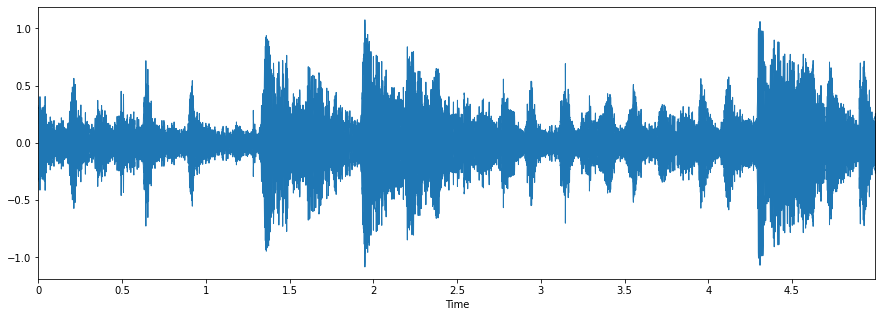

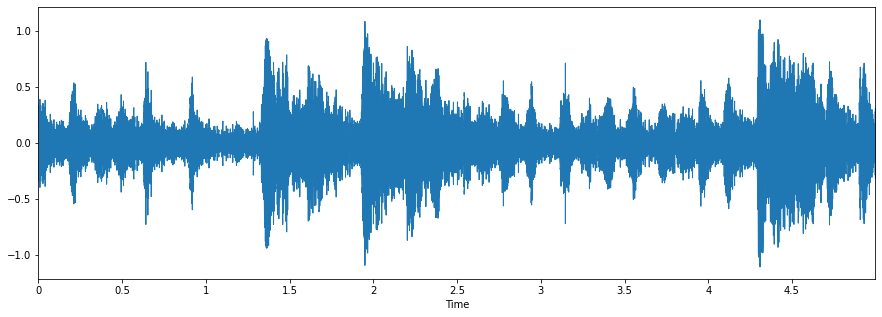

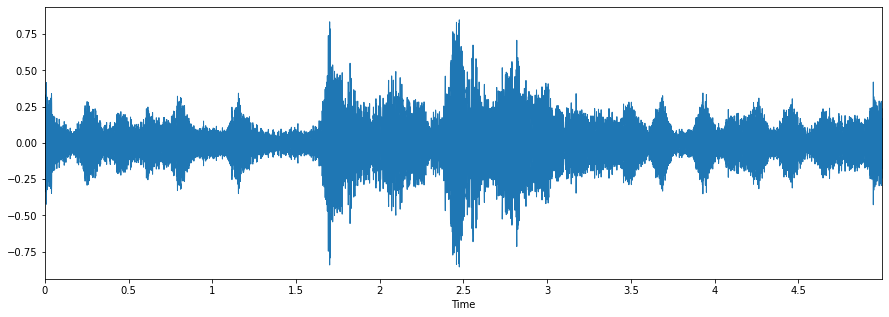

In [103]:
# train-test splits
X_train, X_test, y_train, y_test = train_test_split(music, styles, test_size=0.5)
y_train2 = np.hstack((y_train, y_train))
y_test2 = np.hstack((y_test, y_test))

# augment data
sample_len = len(X_train[0])
aug_rest = np.vstack((X_train.copy(), X_train.copy()))
for i in range(len(X_train)):
    rest_index = np.random.randint(0, len(rest) - 3 - sample_len)
    rest_sample = rest[rest_index:rest_index+sample_len]
    aug_rest[i] += rest_sample


aug_stretch = np.vstack((X_train.copy(), X_train.copy()))
for i in range(len(X_train)):
    stretch = librosa.effects.time_stretch(X_train[i], rate=0.8)
    aug_stretch[i] = stretch[:sample_len]

# visualize to see if noise was added    
plt.figure(figsize=(15,5))
librosa.display.waveplot(X_train[0])
plt.show()
plt.figure(figsize=(15,5))
librosa.display.waveplot(aug_rest[0])
plt.show()
plt.figure(figsize=(15,5))
librosa.display.waveplot(aug_stretch[0])
plt.show()

<h3 align="center"> Problem 4</h3>

Do the following steps 5 times:

• Use the original data set and the augmented data sets to fit three RandomForestClassifiers,
one only on the original data, one on the original data and the data with ambient noise
added, and one on the original data and the time stretched data.

• Score each classifier.

Print the mean score for each of the classifiers and print the standard deviation for the scores.


In [104]:
# PLP tranform all data
plp_X_train = np.apply_along_axis(librosa.beat.plp, arr=X_train, axis=1)
plp_aug_rest = np.apply_along_axis(librosa.beat.plp, arr=aug_rest, axis=1)
plp_aug_stretch = np.apply_along_axis(librosa.beat.plp, arr=aug_stretch, 
                                      axis=1)
plp_X_test = np.apply_along_axis(librosa.beat.plp, arr=X_test, axis=1)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=384 is too small for input signal of length=216
  n_fft, y.shape[-1]


In [106]:
orig = []
amb = []
time = []

for i in range(5):
    # fit and score 3 random forest classifiers
    orig_model = RandomForestClassifier().fit(plp_X_train, y_train)
    amb_model = RandomForestClassifier().fit(plp_aug_rest, y_train2)
    time_model = RandomForestClassifier().fit(plp_aug_stretch, y_train2)

    orig.append(orig_model.score(plp_X_test, y_test))
    amb.append(amb_model.score(plp_X_test, y_test))
    time.append(time_model.score(plp_X_test, y_test))

# print results
orig = np.array(orig)
amb = np.array(amb)
time = np.array(time)

print('\t\t Mean \t STD')
print('Original','\t',np.round(orig.mean(),3),'\t',np.round(orig.std(),3))
print('Ambient Noise','\t',np.round(amb.mean(),3),'\t',np.round(amb.std(),3))
print('Time Stretch:','\t',np.round(time.mean(),3),'\t', np.round(time.std(),3))

		 Mean 	 STD
Original 	 0.507 	 0.03
Ambient Noise 	 0.536 	 0.005
Time Stretch: 	 0.472 	 0.018


<h2 align="center">SMOTE</h2>

<h3 align="center"> Problem 5 </h3>

Write a function that uses the synthetic minority oversampling technique to augment an imbalanced data set.
Your function should have the following characteristics:

Accept $X$, a matrix of minority class samples
       $N$, the number of samples to generate per original point
       $k$, the number of nearest neighbors.

For each original point in the sample, pick one of the $k$ nearest neighbors at random and generate a new point that lies between the two original values. 

Return an array containing the synthetic samples.


In [82]:
def smote(X,N,k):
    """ Generate synthetic points using the SMOTE method. Hint! Use KDTree :)
    Parameters:
        X (n,m): minority class samples
        N (int): number of samples to generate from each point
        k (int): number of nearest neighbors
    Returns:
        synthetic ndarray(N*n,m): synthetic minority class samples
    """
    # generate K neighbors tree
    tree = KDTree(X)
    m = X.shape[1]
    n = X.shape[0]
    # initialize synthetic array
    synthetic = np.empty((N*n, m))

    for i in range(len(X)):
        point = X[i]
        dist, ind = tree.query(point.reshape(1, -1), k) # find k neighbors
        ind = ind[0]
        # sample N points in the interval
        for j in range(N):
            # choose a random neighbor
            neighbor = X[np.random.choice(ind)]
            # sample new point
            diff = neighbor - point
            new_point = np.random.sample(size=m)*diff + point

            # add to synthetic
            synthetic[N*i + j] = new_point
            
    return synthetic

<h3 align="center"> Problem 6 </h3>

The dataset found in creditcard.npy contains information about credit card purchases made over a two day period. 
Of the approximately 285,000 observations, 492 are fraudulent purchases. 
The last column indicates if the purchase was valid (0) or fraudulent (1). 

Do the following steps 10 times:

• Create a training and test set from the data using train_test_split from sklearn.
model_selection with test_size=.7.

• Use smote with N = 500 and k = 2 to augment the training set.

• Create two Gaussian Naïve Bayes classifiers (from sklearn.naive_bayes.GaussianNB),
one which wil be trained on only the original data and the other on the SMOTE augmented
data and the original data.

• Fit each classifier and find the recall and accuracy of each model.

Print the mean recall and mean accuracy of each model and and describe the findings.

In [99]:
# load data
credit = np.load("creditcard.npy")
X = credit[:, :-1]
y = credit[:, -1]
N = 500
k=2

# get ready to store recalls/accuracies for averaging later
orig_recalls = []
aug_recalls = []
orig_accs = []
aug_accs = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)
    synthetic = smote(X_train[y_train==1], N, k)
    # create synthetic true values
    y_train_synthetic = np.ones(shape=(N*y_train[y_train==1].shape[0]))
    # for index in range(len(y_train[y_train==1])):
    #     for p in range(N):
    #         y_train_synthetic[N*index + p] = 1
    # add back the original
    y_train_synthetic = np.hstack((y_train, y_train_synthetic))
    # create classifiers
    original = GaussianNB().fit(X_train, y_train)
    augmented = GaussianNB().fit(np.vstack((X_train, synthetic)), 
                                           y_train_synthetic)
    orig_pred = original.predict(X_test)
    aug_pred = augmented.predict(X_test)

    orig_recalls.append(recall_score(y_test, orig_pred))
    aug_recalls.append(recall_score(y_test, aug_pred))
    orig_accs.append(accuracy_score(y_test, orig_pred))
    aug_accs.append(accuracy_score(y_test,aug_pred))

# compute means and print
mean_orig_recall = np.mean(orig_recalls)
mean_orig_score = np.mean(orig_accs)
mean_smote_recall = np.mean(aug_recalls)
mean_smote_score = np.mean(aug_accs)
print('\t\t Recall \t Accuracy')
print('Original','\t',np.round(mean_orig_recall,5),'\t', np.round(mean_orig_score,5))
print('SMOTE', '\t\t', np.round(mean_smote_recall,5), '\t', np.round(mean_smote_score,5))


		 Recall 	 Accuracy
Original 	 0.66433 	 0.99282
SMOTE 		 0.76391 	 0.99131
